In [2]:
import torch
import detectron2

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

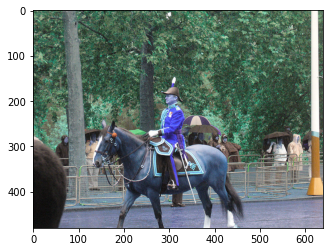

In [3]:
im = cv2.imread("./input.jpg")
plt.imshow(im)
plt.show()

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

AssertionError: Torch not compiled with CUDA enabled

In [5]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

NameError: name 'outputs' is not defined

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

NameError: name 'outputs' is not defined

# Train on a custom dataset
In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [4]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts



for d in ["train", "val"]:
    print("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    DatasetCatalog.register("balloon_" + d, lambda g=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

balloon_train <function <lambda> at 0x7febed716290>
balloon_val <function <lambda> at 0x7feb934d8e50>


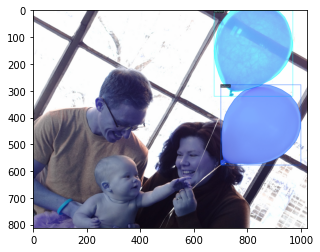

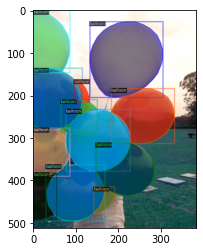

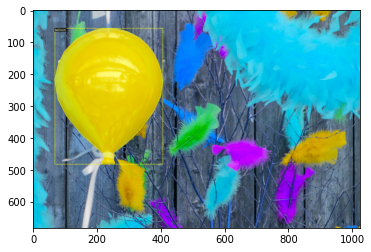

In [5]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/01 14:57:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/01 14:57:51 d2.engine.train_loop]: Starting training from iteration 0
[07/01 14:57:55 d2.utils.events]:  eta: 0:00:23  iter: 19  total_loss: 2.132  loss_cls: 0.7064  loss_box_reg: 0.6073  loss_mask: 0.6841  loss_rpn_cls: 0.05727  loss_rpn_loc: 0.01359  time: 0.0869  data_time: 0.0250  lr: 1.6068e-05  max_mem: 2460M
[07/01 14:57:57 d2.utils.events]:  eta: 0:00:23  iter: 39  total_loss: 1.94  loss_cls: 0.6086  loss_box_reg: 0.6329  loss_mask: 0.5952  loss_rpn_cls: 0.03381  loss_rpn_loc: 0.00739  time: 0.0913  data_time: 0.0131  lr: 3.2718e-05  max_mem: 2460M
[07/01 14:57:59 d2.utils.events]:  eta: 0:00:22  iter: 59  total_loss: 1.604  loss_cls: 0.4502  loss_box_reg: 0.6422  loss_mask: 0.4728  loss_rpn_cls: 0.02145  loss_rpn_loc: 0.008252  time: 0.0921  data_time: 0.0071  lr: 4.9367e-05  max_mem: 2563M
[07/01 14:58:01 d2.utils.events]:  eta: 0:00:20  iter: 79  total_loss: 1.39  loss_cls: 0.3599  loss_box_reg: 0.6942  loss_mask: 0.3869  loss_rpn_cls: 0.02229  loss_rpn_loc: 0.007991  ti

In [11]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir output --port 6060

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [6]:
cfg = get_cfg()
if not torch.cuda.is_available():
    print('CUDA not available, resorting to CPU')
    cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

CUDA not available, resorting to CPU


In [7]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

AssertionError: Checkpoint ./output/model_final.pth not found!

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

NameError: name 'predictor' is not defined